## Introduction

In this guide, we'll learn how to detect near duplicate comments on rulemakings using MinHash! Before we begin, let's briefly review what we're trying to accomplish.

We have a lot of comments on agency rulemakings. For example (and we'll revisit this example throughout), consider the proposed rule entitled [*Remote Identification of Unmanned Aircraft Systems*](https://www.regulations.gov/document?D=FAA-2019-1100-0001). Contained within the [docket](https://www.regulations.gov/docket?D=FAA-2019-1100) are 53,211 comments. The comments are mostly plain text, totalling 13,887,832 words—that's 23 times as long as *War and Peace* (587,287 words) and 12 times as long as the entire *Harry Potter* series (1,084,170 words). An average college student, reading at [450 words per minute](https://www.forbes.com/sites/brettnelson/2012/06/04/do-you-read-fast-enough-to-be-successful/#5863fed2462e), would need just over 514 hours to read all the comments (that's 13 full work weeks!). And this doesn't even count attachments, of which there are 6,915. However, because any type of file can be attached, they're rather hard to process, and we'll ignore them for our purposes. Bottom line: there's a lot of comments.

Thus, whether you're a lone academic looking to understand commenting behavior, or the FAA attempting to respond to these comments, you'd be wise to employ some sort of automatic technology to sort through, organize, analyze, and understand these comments.

One common pattern of comments is the *form comment*. These are comments that are substantially identical. They likely started life as a form—as in, a mostly complete document to be filled out. Then, either a human or a computer came through and filled out the form, customizing the comment somewhat. Large organizations sometimes organize mass comment campaigns—they draft form comments and distribute them to their memberships, who then fill in their names and perhaps slightly customize the comments in other ways and submit them as individuals. 

For any number of reasons, we might want to identify and isolate groups of form comments (and there will be groups—sometimes there are multiple interested institutions, other times a single institution prepares multiple forms).

Another way to state the problem is that we want to find *near duplicates*—form comments are rarely exact duplicates, they're defintionally forms that are filled out and customized. But, as with any sort of form, much of the text remains unchanged. Thus, while they may not be exact textual duplicates, they are near duplicates.

This guide will introduce several key principles and techniques of natural language processing (NLP) in a informal, intuitive style. In the process, we'll learn a bit about how computers work, and the various challenges one might face during an NLP project (i.e., a project that involves analyzing human language, like English). Note, however, that many of the ideas discussed here can be applied across many domains, even outside the natural langauge processing context. 

This guide is written for people with minimal technical and mathematical ability. There will be math, and there will be code. But we'll first develop an intuitive, conceptual understanding of how things work. Then we'll look at the code and the equations—take a careful look, but if it's beyond you, you can still proceed without substantially harming your understanding.

All the code you see here is real, working Python code. Feel free to change it and run it! Even if you don't know how to program, take a look at the code—some of it may be more comprehensible than you'd expect.

First, let's set up three very basic comments. Later on, we'll look at some real-deal comments. But, for now, it'll be easier to work with shorter comments.

In [1]:
comment_A = "Hello, my name is Alice and I have a comment."
comment_B = "Hello, my name is Bob and I have a comment."
comment_C = "Hello, my name is Charlie and I hate federal rulemakings."

## How Computers Work, Part I: How They See Data

It's important to remember that, to us, text often has rich semantic meaning, like in the comments above.

But, to a computer, text is just a bunch of meaningless numbers. Computers, by themselves, know nothing of the world. They see no meaning in text. For example, within computer memory, the word "HI" would be stored as 72 73 (when [encoded](https://en.wikipedia.org/wiki/Character_encoding) in [ASCII](https://en.wikipedia.org/wiki/ASCII)—basically a matter of looking up each text character in a standardized table that maps from characters to numbers). Or, if you prefer [binary](https://en.wikipedia.org/wiki/Binary_number), 01001000 01001001. 

Although the purpose of this notebook is not to teach about [positional numeral systems](https://en.wikipedia.org/wiki/Numeral_system#Positional_systems_in_detail), it's worth knowing that binary is just another way of writing numbers (no different than, say, tick marks or Roman numerals in that respect). All those "1s and 0s" (or, more practically, high and low voltages) flowing around inside your computer—they're all just numbers. Of course, they often represent different things. This includes data, like Boolean values (true/false), text, images, sounds, and so forth. And it also includes [logical](https://en.wikipedia.org/wiki/Truth_function) (e.g., AND, as in: true AND false is false) and [arithmetical](https://en.wikipedia.org/wiki/Arithmetic#Arithmetic_operations) (e.g., +, as in: 1 + 2 is 3) operations.

This is also true of our comments here. Take comment A for example. We can view its numerical representation in both decimal and binary:

In [2]:
decimal = [ord(character) for character in comment_A]
print(' '.join([str(number) for number in decimal]))

72 101 108 108 111 44 32 109 121 32 110 97 109 101 32 105 115 32 65 108 105 99 101 32 97 110 100 32 73 32 104 97 118 101 32 97 32 99 111 109 109 101 110 116 46


In [3]:
binary = [format(number, '#010b') for number in decimal]
print(''.join([number[2:] for number in binary]))

010010000110010101101100011011000110111100101100001000000110110101111001001000000110111001100001011011010110010100100000011010010111001100100000010000010110110001101001011000110110010100100000011000010110111001100100001000000100100100100000011010000110000101110110011001010010000001100001001000000110001101101111011011010110110101100101011011100111010000101110


## Preprocessing

A standard first step in any natural language project is [preprocessing](https://en.wikipedia.org/wiki/Data_pre-processing)—preparing the text of each "document" (each comment) in the "corpus" (the collection of all comments).

The basic notion of preprocessing is straightforward. Before we do any analysis, we need to get the data into a usable form. 

We need to account for the limitations of computers:
- Remember, computers will view "HI" and "hi" as two entirely different pairs of numbers (72 73 and 104 105, respectively, under ASCII). Thus, we might want to control for case (for example, by converting all text to lower case).
- We need to account for various oddities that may appear in the data (for example, when handling strings in computers, it's not uncommon to see [control characters](https://en.wikipedia.org/wiki/Control_character) represented as text—for example rather than a paragraph break, you might see the character "\n"). And, thanks to the advent of [Unicode](https://en.wikipedia.org/wiki/Unicode), one can have all kinds of odd characters, like 🦄, 🀚, and 🝒. These might not add much meaning and can be inconvenient to work with, so we might want to strip them away entirely.
- We need to account for misspellings of words (again "appearance" and "apperence" will be represented differently within the computer, and the computer will not grasp any semantic connection between the two in the way we might). 
- We need to account for the fact that some words mean have virtually identical semantic meanings and similar grammatical roles (like "is," "are," and "be"). An easy way to get the computer to see them as the same is to, well, make them the same! This might be accomplished via [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation)—it sounds fancy, but lemmatizers basically work by looking up each word in a database to see if it should be mapped to a "lemma" or "dictionary form" (i.e., the simplest version of the word). Similarly, we might want to perform [stemming](https://en.wikipedia.org/wiki/Stemming)—a less elegant but more extensible approach that involves converting words to their stems by chopping off the common inflectional prefixes and sufixes (like "-ing" from verbs).

While preprocessing, we also often perform *tokenization*. We split the text into minimal units of meaning, which we call "tokens," so that each token can be internally represented by a single number. We've seen that, by default, computers see strings of text as strings of numbers. "Hi" is understood by the computer as consisting of two numbers stored next to each other in memory: "H" (encoded as 72) and "i" (encoded as 105). It's often more useful if the numbers within the computer can represent whole words (i.e., units of meaning), rather than characters. A natural solution is to split text at each space, and assign the resultant words to numbers. But, then, is better to understand "isn't" as a single token ("isn't") or as two ("is" and "n't")?

But we also need to account for the human element. What are we trying to accomplish? How are humans producing and modifying the text at issue? If, say, we have two comments that read "Hi, I have a comment" and "hi, i have a comment"—is it fair to say these are form comments that we would want to group together? Perhaps if, between two comments, the words use different cases, spellings, inflections, and so forth, then they are in fact not form comments as we would conventionally think of them. Perhaps it's just a matter of (some degree of) design convergence between two bespoke comments.

For our purposes, because we are looking for portions of identical text in form comments, it's reasonable to take a light touch during the preprocessing phase. To make some of the visualizations that follow a bit cleaner, we'll just convert everything to lower case, strip all control characters, strip all non-ASCII characters (like the Unicode 🦄), strip all punctuation, and tokenize into words by splitting the text at each space.

In [4]:
import string

def preprocess(comment):
    # Make the whole comment lower case
    comment = comment.lower()
    
    # Remove any non-ASCII characters
    comment = comment.encode('ascii', 'ignore').decode('utf-8')
    
    # Remove all control characters
    comment = ''.join(character for character in comment if ord(character) >= 32)
    
    # Remove all punctuation
    comment = ''.join(character for character in comment if character not in string.punctuation)
    
    # Tokenize
    comment = comment.split(' ')
    
    return comment

comment_A = preprocess(comment_A)
comment_B = preprocess(comment_B)
comment_C = preprocess(comment_C)

print(comment_A)
print(comment_B)
print(comment_C)

['hello', 'my', 'name', 'is', 'alice', 'and', 'i', 'have', 'a', 'comment']
['hello', 'my', 'name', 'is', 'bob', 'and', 'i', 'have', 'a', 'comment']
['hello', 'my', 'name', 'is', 'charlie', 'and', 'i', 'hate', 'federal', 'rulemakings']


## *n*-Grams and *k*-Shinglings

A very important concept in NLP is that of the *n*-gram. An *n*-gram is a continguous sequence of *n* tokens selected from a document. The smallest *n*-gram is the 1-gram, better known as the *unigram*, which is just a single token or, in our case, a single word. Bigrams (2-grams) are pairs of adjacent tokens or words. Trigrams (3-grams) are collections of three contiguous tokens or words. 

Let's look at the *n*-grams for comment A:

In [5]:
import nltk

for i in range(1, len(comment_A)+1):
    print(str(i) + '-grams:')
    for ngram in nltk.ngrams(comment_A, i):
        print('\t' + str(ngram))

1-grams:
	('hello',)
	('my',)
	('name',)
	('is',)
	('alice',)
	('and',)
	('i',)
	('have',)
	('a',)
	('comment',)
2-grams:
	('hello', 'my')
	('my', 'name')
	('name', 'is')
	('is', 'alice')
	('alice', 'and')
	('and', 'i')
	('i', 'have')
	('have', 'a')
	('a', 'comment')
3-grams:
	('hello', 'my', 'name')
	('my', 'name', 'is')
	('name', 'is', 'alice')
	('is', 'alice', 'and')
	('alice', 'and', 'i')
	('and', 'i', 'have')
	('i', 'have', 'a')
	('have', 'a', 'comment')
4-grams:
	('hello', 'my', 'name', 'is')
	('my', 'name', 'is', 'alice')
	('name', 'is', 'alice', 'and')
	('is', 'alice', 'and', 'i')
	('alice', 'and', 'i', 'have')
	('and', 'i', 'have', 'a')
	('i', 'have', 'a', 'comment')
5-grams:
	('hello', 'my', 'name', 'is', 'alice')
	('my', 'name', 'is', 'alice', 'and')
	('name', 'is', 'alice', 'and', 'i')
	('is', 'alice', 'and', 'i', 'have')
	('alice', 'and', 'i', 'have', 'a')
	('and', 'i', 'have', 'a', 'comment')
6-grams:
	('hello', 'my', 'name', 'is', 'alice', 'and')
	('my', 'name', 'is', 'a

The use of *n*-grams is extremely common in NLP. It's a simple concept, but it's important to understand.

The value of the *n*-gram lies in its capturing some of the context around each word. Words have semantic value—meaning—on their own. But context, structure, grammar, and word order all greatly bear on the meaning of text. An *n*-gram captures (some) word order. For our purposes, we want to make sure that comments not only use some of the same words, but use them in some of the same orders before we declare them near duplicates.

A related and important concept is that of the [*bag of words*](https://en.wikipedia.org/wiki/Bag-of-words_model). Many NLP techniques treat documents as ["bags"](https://en.wikipedia.org/wiki/Multiset) of words. Simply stated, given a document, we ignore the structure and order of words—the algorithm treats the document as an unordered list of all its words. If a word appears multiple times in the document, then it appears multiple times in the list. But the list is like an actual bag: devoid of any internal structure or order—all the words from the document, all jumbled up. Many of these techniques can be enhanced by using *n*-grams, rather than words, as tokens (creating a bag of *n*-grams).

Another related concept is that of *k*-shingling. Succinctly, the [*k*-shingling](https://en.wikipedia.org/wiki/W-shingling) of a document is the set of all *k*-grams. Less succinctly, but to be clear on terminology, an *k*-gram is a single collection of *k* contiguous words. We can generate a list of all *k*-grams for a document, but that list will include some duplicate *k*-grams. But, in a mathematical [set](https://en.wikipedia.org/wiki/Set_(mathematics)), all the elements must be unique. In other words, if there are two identical *k*-grams, we must remove one of them. A *k*-shingling of a document, then, is all the unique *k*-grams of a document. We refer to each unique *k*-gram in a *k*-shingling as a "*k*-shingle."

To use a concrete example, let's take a look at the 2-shingling of the comment "SciReg is a class at Duke. SciReg is a very interesting class." Take note of whether there's a difference between the list of bigrams and the 2-shingling.

In [6]:
text = "SciReg is a class at Duke. SciReg is a very interesting class."
preprocessed = preprocess(text)
bigrams = list(nltk.ngrams(preprocessed, 2))
two_shingling = set(bigrams)

print('All 2-grams:')
for bigram in bigrams: print('\t' + str(bigram))
print('All 2-shingles:')
for shingle in two_shingling: print('\t' + str(shingle))

All 2-grams:
	('scireg', 'is')
	('is', 'a')
	('a', 'class')
	('class', 'at')
	('at', 'duke')
	('duke', 'scireg')
	('scireg', 'is')
	('is', 'a')
	('a', 'very')
	('very', 'interesting')
	('interesting', 'class')
All 2-shingles:
	('very', 'interesting')
	('duke', 'scireg')
	('class', 'at')
	('interesting', 'class')
	('a', 'very')
	('a', 'class')
	('scireg', 'is')
	('is', 'a')
	('at', 'duke')


Note that *k*-shinglings are in some sense similar to the bag of words model (or, perhaps more aptly, bag of *n*-grams). Unlike bags of words, they are not *bags* in the technical, mathematical sense. Bags (also known as multisets), expressly permit duplicate elements (words), while *k*-shinglings are sets of unique elements (shingles). They are similar, however, in that they both ignore any structure among their elements. Shingles, of course, internally contain structure in the form of word order. But connections between different shingles are ignored within a *k*-shingling.

We've now developed the requisite concepts to begin our analysis and our objective of learning MinHash. We'll divide the bulk of our analysis into three steps: (1) shingling, (2) MinHash, and (3) locality sensitive hashing.


## Step One: Shingling the Comments


The first step should be easy. We've already covered it. We need to shingle our comments.

There's really only one question: how long should our shingles be? Stated fully in the jargon, what value of *k* should we select in generating the *k*-shinglings of our comments?

The logic behind this will become clearer as we move to Step Two and examine the Jaccard index. In the meantime, suffice to say that we want shingles that are sufficiently long that they rarely appear in comments. Lots of comments use the same words (unigrams or 1-shingles). But fewer comments will reuse longer strings of contiguous words, and where they do, it's a stronger indication that we've identified a near duplicate.

Because our test comments are very short, we'll use 2-shinglings (as a practical matter, these are also convenient to understand and visualize later on). Picking a greater *k*, however, would not be unreasonable. For our real-deal, full-length comments, a greater *k* would almost certainly be preferable.

In [7]:
shingling_A = set(nltk.ngrams(comment_A, 2))
shingling_B = set(nltk.ngrams(comment_B, 2))
shingling_C = set(nltk.ngrams(comment_C, 2))

## Step Two: MinHash, Part I (The Jaccard Index)

Step two will be the most challenging part of our work. 

Before we think about how to find groups of near-duplicate comments, let's consider how we might determine whether two comments are near duplicates. If there is a means of measuring how similar two comments are, then, if the measure exceeds some threshold, we might declare them similar enough to be near duplicates. What options are there for measuring the similarity of two comments?

One option for measuring the similarity between two sets is the Jaccard index (also called the "Jaccard similarity"). And, remember, we've decided to treat our comments as 2-shinglings: sets of bigrams. Thus, we can use the Jaccard index to assess the similarity of our comments-as-2-shinglings.

In simple terms, the Jaccard index is equal to the number of elements two sets have in common, divided by the total number of elements in both sets. The Jaccard index will be a value from 0 (sets have nothing in common—in the jargon, they're "disjoint") to 1 (sets are equal).

More formally, the Jaccard index of two sets A and B is given by 
\begin{equation} 
J(A,B) = \frac{|A \cap B|}{|A \cup B|}
\end{equation}

To briefly describe the mathematical notation, in the numerator of the fraction, the operator (∩) between A and B is the [intersection](https://en.wikipedia.org/wiki/Intersection_(set_theory)) operator—it yields the set of all elements that are in both A and B. The two bars (||) on either side of the intersection denote the [number of elements](https://en.wikipedia.org/wiki/Cardinality) in the intersection. The denominator is very similar, except it features the [union](https://en.wikipedia.org/wiki/Union_(set_theory)) operator (∪), which is the set of all elements that are contained either in A, or in B, or in both A and B.

Let's take a look at what this means for our comments A, B, and C by our comments-as-2-shinglings in Venn diagrams. In particular, let's look at the Venn diagram for comments A and B, and comments A and C. Then, we'll compute the Jaccard indices between A and B and between A and C.

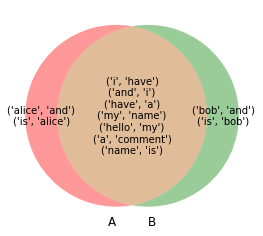

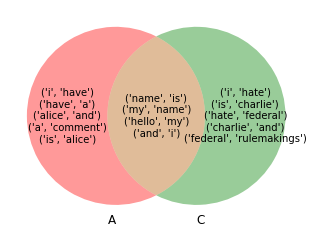

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib_venn import venn2

v1 = venn2([shingling_A, shingling_B], ['A', 'B'])
v1.get_label_by_id('100').set_text('\n'.join([str(shingle) for shingle in shingling_A - shingling_B]))
v1.get_label_by_id('010').set_text('\n'.join([str(shingle) for shingle in shingling_B - shingling_A]))
v1.get_label_by_id('110').set_text('\n'.join([str(shingle) for shingle in shingling_A.intersection(shingling_B)]))
plt.figure()


v2 = venn2([shingling_A, shingling_C], ['A', 'C'])
v2.get_label_by_id('100').set_text('\n'.join([str(shingle) for shingle in shingling_A - shingling_C]))
v2.get_label_by_id('010').set_text('\n'.join([str(shingle) for shingle in shingling_C - shingling_A]))
v2.get_label_by_id('110').set_text('\n'.join([str(shingle) for shingle in shingling_A.intersection(shingling_C)]))
plt.figure()
plt.show()
plt.close()

As the Venn diagrams above reflect, there is substantial overlap between comments A and B—understandably so, they're identical except for the name (ordinarily be a strong indication of a form comment). Meanwhile, there is much less overlap between comments A and C.

Visually, to compute the Jaccard index for, say, comments A and B, we would count the number of shingles in the overlapping region in Figure 1. Then, we would count the number of all the shingles in the entire Venn diagram. And then we would divide the first number by the second.

Programmatically, this is quite easy:

In [9]:
def jaccard(X, Y):
    return len(X.intersection(Y))/len(X.union(Y))

print('Jaccard index of comments A and B: ' + str(jaccard(shingling_A, shingling_B)))
print('Jaccard index of comments A and C: ' + str(jaccard(shingling_A, shingling_C)))
print('Jaccard index of comments B and C: ' + str(jaccard(shingling_B, shingling_C)))

Jaccard index of comments A and B: 0.6363636363636364
Jaccard index of comments A and C: 0.2857142857142857
Jaccard index of comments B and C: 0.2857142857142857


Unsuprisingly, the Jaccard index of A and B is fairly high—those are our form comments. Meanwhile, the Jaccard index between A and C is low. The Jaccard index between B and C is equally low (also unsurprising, because A and B are identical except for a single word, neither word is anywhere to be found in C).

So, are we done? Do we simply shingle all our comments, compute the Jaccard indices between them all, and pick out the ones with high Jaccard indices?

Not quite. There's a substantial drawback to directly computing the Jaccard index that is masked by the simplicty of the code we've seen so far. To understand that drawback, we must take a brief detour.

## How Computers Work, Part II: Computational Complexity

We've already discussed how computers store and see data. But how do computers actually process data? That is, how do they *compute*? 

A full explanation of [computer architecture](https://en.wikipedia.org/wiki/Computer_architecture) is beyond the scope of this guide, but a basic understanding is helpful, so we'll cover a simplified model. As you may know, at the heart of all computers is the [central processing unit](https://en.wikipedia.org/wiki/Central_processing_unit), or CPU. 

The CPU is connected to the computer's [memory](https://en.wikipedia.org/wiki/Computer_memory), typically RAM. At some point, all data will be loaded into memory, often from some secondary storage device, like a hard drive (HDD) or solid-state drive (SSD). Memory might be analogized to a row of [lockers](https://en.wikipedia.org/wiki/Locker). We've all seen rows of lockers with big numbers on the front—addresses which identify the locker. And, within the locker, you can fit a fixed amount of stuff. You can change the contents of the locker, taking stuff out, putting stuff in. After some period of time, whether you like it or not, someone will clean out the lockers. This analogy illustrates several ideas about computer memory: data is stored at particular, numerical addresses. Each location in memory can contain a fixed amount of data. You can read and write data from/to memory at particular addresses. And, as is the case with [DRAM](https://en.wikipedia.org/wiki/Dynamic_random-access_memory), memory can be remarkably ephemeral once the power goes out.

Within the CPU itself, you'll find several more components: registers (which, for the most part, function similar to memory), the arithmetic logic unit (better known as the ALU, which performs, as the name suggests, arithmetical and logical operations), and the control unit (which coordinates between the ALU, memory, and input/output devices, telling them what operations to perform).

Like data, the program—the set of instructions which the computer will execute—is also stored in memory. To run programs, the CPU follows the [instruction cycle](https://en.wikipedia.org/wiki/Instruction_cycle). In short, a special register called the program counter (PC) stores the memory address of the next instruction to be executed. When it is time to execute that instruction, the CPU copies the contents of the PC into another register and then increments the PC, so that it again points to the next instruction to be executed. With the copy of the PC, the CPU can call up the instruction out of memory. Just the same as data, the instruction is represented as a binary number which is decoded by the control unit, which, depending on the instruction, might for example send a series of signals to the ALU to have it carry out some basic computation. (Note that on modern computers there tend to be other units similar to the ALU, like floating point units, which also carry out certain basic computations.)

The instructions that a CPU can carry out are very basic. The ALU provides simple logical operations, for example the logical operation AND will return 1 if two bits are both 1, and 0 otherwise. The logical operation OR, meanwhile, returns 1 if either of two bits are 1, and 0 otherwise. The ALU also provides basic arithmetic like addition and subtraction. Other instructions, for which the control unit is ordinarily responsible, might copy or move data—for example, an instruction to load data from memory into a register is, on [some architectures](https://en.wikipedia.org/wiki/Load%E2%80%93store_architecture) (though probably not yours), a prerequisite for further processing of the data through the ALU.

There are thus two fundamental resources (sometimes colloquially referred to as "compute") that programmers tend to be very concerned about: instructions and memory. 

Programs are, fundamentally, a series of instructions. While high-level programming languages, like Python (which we've been using so far), let us easily write "instructions" that are far more complex than the basic instructions provided by the architecture of the computer, all programs, no matter the language, must ultimately be boiled down to those basic instructions. Importantly, a single CPU can only perform a single instruction at once (a slight oversimplification—especially as many computers are now [multicored](https://en.wikipedia.org/wiki/Multi-core_processor)). And although operations are executed seemingly instantaneously, they actually require some miniscule amount of time.

Different programs will need to execute a different number of instructions. The number of instructions that a program will need to execute may depend on the amount of data it takes as input. For example, imagine a simple program that takes as input a list of numbers and adds 1 to each number. In terms of the CPU, we might need operations to extract the each number from memory, increment it (an operation typically provided by the ALU), and return it to memory. And, remember, we would need to do this for each number in the list. As the list of numbers increases in length, the number of required operations also increases. If the list becomes extremely long, the seemingly instantaneous operations may become so numerous that, in bulk, they no longer seem instantaneous at all.

Memory, too, is be a limited resource. Programs are, as discussed, stored in memory, but so is the data over which the programs operate. Programs often require "work memory," temporarily storing various values in memory so they can be referred to by some later operation in the program. It's neither the input nor the output—but memory usage in running the program. The amount of memory a program needs to execute may likewise scale with the size of the input.

The preceding two paragraphs introduce two central ideas of computer science: time complexity and space complexity, collectively referred to as [computational complexity](https://en.wikipedia.org/wiki/Computational_complexity). 

For the time being, we'll focus on time complexity. The basic notion is this: there are different classes of programs. Some classes will require far more operations (and thus far more time) to complete than others as the size of the input increases.

In some classes, the program will execute in the same amount of time no matter the size of the input. Imagine a program that accesses a single value from memory—no matter the size of the memory given as input, all it needs to do is retrieve the value stored at a particular address, and it happens in a single operation. We say these programs run in "constant time." 

In other classes, the time needed for the program to execute will scale linearly with the size of the input. Previously, we discussed a program that would add 1 to each number in a list of numbers. In such a program, each time another number is added to the list, the number of operations required will increase by a fixed amount. Such programs run in linear time. If the list is 500 numbers long, we will need 500*c* operations, where *c* is the number of operations required to increment a single number. If the list is *n* numbers long, we can write the number of operations required as *n*×*c*. But computer scientists would ordinarily just record this as *n*, or [O(n)](https://en.wikipedia.org/wiki/Big_O_notation).

Computational complexity is of great interest in the big data context because the data is, definitionally, big. Computational complexity asks (and provides a means to answering) how much time and memory a program will take as the input data increases in size. When you're dealing with huge input data, this is a very important question. 

As a final note, even if you are not a computer scientist, you may have heard of computational complexity in other contexts before. For example, the iconic [P vs NP problem](https://en.wikipedia.org/wiki/P_versus_NP_problem) fundamentally asks whether all non-polynomial time algorithms (e.g., exponential time algorithms that might have, for example one that runs in O(2<sup>n</sup>)) can be rewritten as a much faster polynomial time algorithm (i.e., algorithms where the time complexity can be written as a [polynomial](https://en.wikipedia.org/wiki/Polynomial) like n<sup>4</sup>). A substantial part of the excitment around [quantum computing](https://en.wikipedia.org/wiki/Quantum_computing) is the ability to write quantum algorithms with significantly reduced [time complexity](https://en.wikipedia.org/wiki/Quantum_complexity_theory).

## Step Two: MinHash, Part II (The Actual MinHash Part) 

Building off the preceding section, let's consider the time complexity of directly computing the Jaccard index. As we know, we first need to compute the intersection of two sets A and B. Let's say we have an element in A, to determine whether the element is in the intersection of A and B, all we need to do is determine if the element is also in B. One option is to take that element in A, and compare it against every element of B, and ask whether the element is equal to any of those elements in B. To compute the full intersection with this approach, we would need to repeat this for every element in A. This is a quadratic time algorithm (siginificantly worse than the two classes of algorithms we discussed int he previous section): the number of operations with scale with the size of set A multiplied by the size of set B. Now, one might imagine faster ways of computing the Jaccard index, but it turns out there's a way of estimating the Jaccard index much faster than you could possibly compute it.

The first step toward understanding MinHash is visualizing sets not as Venn diagrams, but as a table (or, if you prefer a more mathematical term, a matrix). Given our three comments A, B, and C, our rows will represent every shingle in any of the three comments. Our columns will represent the three comments themselves. If a particular shingle appears in a comment, we'll mark the cell with a 1. If not, we'll mark the cell with a 0. Take a look:

In [10]:
import pandas as pd

matrix = pd.DataFrame()
matrix['Elements'] = list(shingling_A.union(shingling_B).union(shingling_C))
matrix['A'] = [1 if element in shingling_A else 0 for element in matrix['Elements']]
matrix['B'] = [1 if element in shingling_B else 0 for element in matrix['Elements']]
matrix['C'] = [1 if element in shingling_C else 0 for element in matrix['Elements']]
    
matrix

,Elements,A,B,C
0,"(i, have)",1,1,0
1,"(i, hate)",0,0,1
2,"(hate, federal)",0,0,1
3,"(charlie, and)",0,0,1
4,"(hello, my)",1,1,1
5,"(name, is)",1,1,1
6,"(federal, rulemakings)",0,0,1
7,"(is, bob)",0,1,0
8,"(bob, and)",0,1,0
9,"(is, charlie)",0,0,1


Say we want to compute the actual Jaccard index of comments A and B. We can count the number of rows where there is a 1 in both columns A and B—these rows are shingles that are contained in both comments and thus are contained within the intersection of A and B. We can also count the number of rows where there is a 1 in one column and a 0 is the other, these are shingles in either A or B, but not both—they are part of the union of A and B, but not the intersection. We can divide the first number by the sum of the first and second numbers to determine the Jaccard index.

In the table below, the rows with 1s in both columns A and B are highlighted yellow and the rows with a 1 in one column and a 0 in the other are highlighted green. Count the rows and see if you can compute the Jaccard index.

In [11]:
matrix.style.apply(lambda x: ['background:lightgreen' if x.name in [0,2,10,11] else 'background:yellow' if x.name in [1,3,4,5,6,12,14] else '' for i in x], axis=1)

,Elements,A,B,C
0,"('i', 'have')",1,1,0
1,"('i', 'hate')",0,0,1
2,"('hate', 'federal')",0,0,1
3,"('charlie', 'and')",0,0,1
4,"('hello', 'my')",1,1,1
5,"('name', 'is')",1,1,1
6,"('federal', 'rulemakings')",0,0,1
7,"('is', 'bob')",0,1,0
8,"('bob', 'and')",0,1,0
9,"('is', 'charlie')",0,0,1


If you've counted correctly, you should've determined that the Jaccard index is 7/11, or about 0.636. Note that this is the same result for the Jaccard index that we found above. We're doing the same operation, but in a slightly different approach.

As a general matter, note that, given any two comments-as-columns, the table has three types of rows:
- Rows with 1s in both columns. These are shingles that appear in both comments (elements in the intersection of the two sets).
- Rows with 1 in one column and 0 in the other. These are shingles that appear in one comment, but not the other (elements in the union of the two sets but not in the intersection of the two sets).
- Rows with 0s in both columns. These are shingles that appear in neither of the two comments, but rather in some other, third comment. 

When comments are very similar, they'll have a lot of shingles in common, so they'll have a lot of the first type of row. When comments are very different, they'll have a lot of the second type of row. 

This brings us to our first attempt at estimating, but not directly computing the Jaccard index. 

Let's say we again want to compute the Jaccard index between comments A and B. We'll randomly shuffle the rows (in mathematical jargon, we might say that we'll *permute* the rows). Then, starting with column A, we'll work our way down the rows and find the first 1 in the column. We'll record the row number that the first 1 appears in. We'll then do the same with column B. 

If the two recorded row numbers are the same, then the first row with a 1 in either A or B represents a shingle in both comments A and B. In essence, we've selected a random shingle in either comment A or comment B, and we've found it's in both comments A and B. As discussed above, this is most likely to happen when the two comments have a lot of shingles in common. In this case, we'll estimate the Jaccard index to be 1.

If the two recorded row numbers are different, then the first row with a 1 in either column represents a shingle that is in one of the comments, but not the other. This is most likely to happen when the two comments have a lot of unique shingles, so we'll estimate the Jaccard index to be 0.

Obviously, our Jaccard estimates will only be 0 or 1, so they're not going to be right. But let's try it a few times anyway. Click the "Permute" button below to randomly shuffle the rows. We'll automatically record the first row with 1 in column A and the first row with 1 in column B (the "signature"). We'll also automatically estimate the Jaccard index, based on the discussion above. And we'll compute the average of all the Jaccard estimates. 

While it may seem trivial, as you click permute, be sure you have some sense of how the signature is generated and how the the estimate is derived from the signature.

In [12]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
permute_button = widgets.Button(description="Permute")
reset_button = widgets.Button(description="Reset")

estimates = []

def reset(b):
    global estimates
    clear_output()
    estimates = []
    print(matrix.reset_index())
    print('Signature:')
    print(' Estimate:')
    print('  Average:')
    print('Based on ' + str(len(estimates)) + ' estimates.')
    display(permute_button, reset_button)

def on_permute_clicked(b):
    clear_output()
    m = matrix.sample(frac=1)
    m = m.reset_index()
    for i in range(len(m.A)):
        if m.A[i] == 1:
            first_1_in_A = i
            break
    for i in range(len(m.B)):
        if m.B[i] == 1:
            first_1_in_B = i
            break
    estimate = int(first_1_in_A == first_1_in_B)
    estimates.append(estimate)
    print(m)
    print('Signature: ' + str((first_1_in_A, first_1_in_B)))
    print(' Estimate: ' + str(estimate)) 
    print('  Average: ' + str(round(sum(estimates)/len(estimates), 2)))
    print('Based on ' + str(len(estimates)) + ' estimates.')
    display(permute_button, reset_button)
          
reset(None)

permute_button.on_click(on_permute_clicked)
reset_button.on_click(reset)

    index                Elements  A  B  C
0       0               (i, have)  1  1  0
1       1               (i, hate)  0  0  1
2       2         (hate, federal)  0  0  1
3       3          (charlie, and)  0  0  1
4       4             (hello, my)  1  1  1
5       5              (name, is)  1  1  1
6       6  (federal, rulemakings)  0  0  1
7       7               (is, bob)  0  1  0
8       8              (bob, and)  0  1  0
9       9           (is, charlie)  0  0  1
10     10                (and, i)  1  1  1
11     11               (have, a)  1  1  0
12     12              (my, name)  1  1  1
13     13            (alice, and)  1  0  0
14     14            (a, comment)  1  1  0
15     15             (is, alice)  1  0  0
Signature:
 Estimate:
  Average:
Based on 0 estimates.


Button(description='Permute', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

As you click "Permute," you should find that the average of the Jaccard estimates for A and B approaches the actual Jaccard index (of about 0.636). Either way, clicking "Permute" all day can be rather tedious. Let's write a program that will randomly permute our rows many (say, 1,000 times). Then we'll graph the average of Jaccard estimates as the number of estimates/permutations increase. We'll also graph the known Jaccard index (of 7/11), so we can see how the average of the estimates converges to the actual Jaccard index.

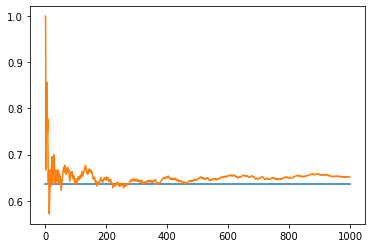

In [13]:
signature = []
# Permute our rows and compute the signature
for i in range(0, 1000):
    # Permute the rows
    m = matrix.sample(frac=1)
    m = m.reset_index()
    
    # Find the first row in column A with 1 in it
    for j in range(len(m.A)):
        if m.A[j] == 1:
            first_1_in_A = j
            break
            
    # Find the first row in column B with 1 in it
    for j in range(len(m.B)):
        if m.B[j] == 1:
            first_1_in_B = j
            break

    # Add the first row numbers to our signature
    signature.append((first_1_in_A, first_1_in_B))

# Calculate Jaccard estimates from signatures  
jaccard_estimates = [int(signature[i][0] == signature[i][1]) for i in range(len(signature))]

# Calculate Jaccard averages from Jaccard estimates
jaccard_averages = [sum(jaccard_estimates[0:i])/len(jaccard_estimates[0:i]) for i in range(1, len(jaccard_estimates)+1)]

# Graph the Jaccard averages
plt.plot([7/11]*len(jaccard_averages))
plt.plot(jaccard_averages)
plt.show()

Let's think carefully about why this works (but stop well short of a mathematical proof).

Think back to the table. When we compare two comments—a pair of columns—we effectively skip over shingles with that appear in neither comment—rows with 0s in both columns. So, intuitively, we don't need to worry about that type of row—we can pretend that they're gone entirely from our table, and our table consists only of two columns (our two comments).

Now, let *x* be the number of rows with 1 in both columns. Let *y* be the number of rows with 1 in one column and 0 in the other. Again, let's ignore the third type of row (where both columns have a 0) for now. We already know that the true Jaccard index is

\begin{equation}
\frac{x}{x+y}
\end{equation}

But, again discarding the rows with 0s in both columns, the probability that the first row will have a 1 in both columns is also

\begin{equation}
\frac{x}{x+y}
\end{equation}

Meanwhile, the probability that the first row will have a 1 in one column but a 0 in the other is

\begin{equation}
\frac{y}{x+y}
\end{equation}

Because we estimate the Jaccard index as 1 when the first row has a 1 in both columns and 0 when the first row has a 1 in one column but a 0 in the other, the expected value of checking the first row is 

\begin{equation}
1 \times \frac{x}{x+y} + 0 \times \frac{y}{x+y} = \frac{x}{x+y}
\end{equation}

In short, the expected value is the Jaccard index. Hence, if we take enough samples—selecting a random "first row" and assessing whether it has a 1 in both columns or just one—the average will converge to the Jaccard index.

So, we now have a means of estimating the Jaccard index. But how does it do in terms of efficiency (computational complexity)? Well, in short, constructing the full matrix and permuting it many times is still rather inefficient. 

The solution, as the name "MinHash" would suggest, lies in [hash functions](https://en.wikipedia.org/wiki/Hash_function). Hash functions are mathematical functions that map data of arbitrary size (i.e., any integer) to fixed-size values. Hash functions are extremely important in computer science.

The basic idea is that we will have a hash function and use it to compute hashes for every shingle. We will select the lowest hash value—the *min*imum *hash*—from the set—in effect, a random shingle (or row). We can repeat this process many times with many different hash functions, each time a new random sampling. Then, to compute the Jaccard index, we can count the number of minimum hashes that are the same and divide it by the total number of minimum hashes.

We won't get into the particulars of how hash functions work, we'll just assume they work. In particular, we'll use a technique called [universal hashing](https://en.wikipedia.org/wiki/Universal_hashing) (chapter 11.3.3 (page 265) of Introduction to Algorithms (3d ed. 2009) by Cormen, Leiserson, Rivest & Stein provides strong coverage). Universal hashing tells us that 

\begin{equation}
h(x) = (ax + b)\mod p
\end{equation}

is a hash function, where 1 < *a* < *p*, 0 < *b* < *p* and *p* is a prime number less than the maximum value of *x*. Thus, it's easy to produce a large number of hash functions.

Let's see this algorithm in action

In [51]:
import mmh3 # we'll use Murmur, a hash function, to quickly convert our shingles to numbers in the first place

k = 1000

M_61 = (1 << 61) - 1

A = random.sample(range(1, M_61), k)
B = random.sample(range(0, M_61), k)

signature_A = []
signature_B = []

for i in range(0, k):
    min_hash = float('inf')
    for shingle in shingling_A:
        hashcode = (A[i]*mmh3.hash(str(shingle)) + B[i]) % M_61
        if hashcode < min_hash:
            min_hash = hashcode
    signature_A.append(min_hash)
    
    min_hash = float('inf')
    for shingle in shingling_B:
        hashcode = (A[i]*mmh3.hash(str(shingle)) + B[i]) % M_61
        if hashcode < min_hash:
            min_hash = hashcode
    signature_B.append(min_hash)
    
count = 0
for i in range(len(signature_A)):
    if signature_A[i] == signature_B[i]:
        count += 1

print('Estimated Jaccard index between comments A and B: ' + str(count / len(signature_A)))

Estimated Jaccard index between comments A and B: 0.629
